# Libraries and versions

In [1]:
#Basic libraries
python_version = !python -V #version 3.7.9
import pandas as pd #version 1.2.4
import numpy as np #version 1.20.1
import seaborn as sns #version 0.11.0
import matplotlib as plt #version 3.3.3

#for analyse multiple features
from sklearn import __version__ as skn #version 0.24.1
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#for model classifier
from catboost import __version__ as ct #0.25.1
from catboost import CatBoostClassifier, Pool

In [2]:
print(f'Python version - {python_version[0][7:]}')
print(f'Pandas version - {pd.__version__}')
print(f'Numpy version - {np.__version__}')
print(f'Seaborn version - {sns.__version__}')
print(f'Matplotlib version - {plt.__version__}')
print(f'CatBoost version - {ct}')

Python version - 3.7.9
Pandas version - 1.2.4
Numpy version - 1.20.1
Seaborn version - 0.11.0
Matplotlib version - 3.3.3
CatBoost version - 0.25.1


# Configurations

## Seaborn

In [3]:
sns.set_palette('inferno')
sns.set_style('darkgrid')

def configuration(graphic_object, title=None, xlabel=None, ylabel=None, colors='black'):
    graphic_object.figure.set_size_inches(15,8)
    graphic_object.set_title(title, color=colors, fontsize=16)
    graphic_object.set_xlabel(xlabel, color=colors, fontsize=14)
    graphic_object.set_ylabel(ylabel, color=colors, fontsize=14)
    graphic_object = graphic_object

## Warning

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Dataset

In [5]:
dataset = pd.read_csv('22_feature_selected.csv')
dataset.head()

,Net Income to Total Assets,Net worth/Assets,Persistent EPS in the Last Four Seasons,Retained Earnings to Total Assets,Net profit before tax/Paid-in capital,Per Share Net profit before tax (Yuan ¥),Working Capital to Total Assets,Net Income to Stockholder's Equity,Net Value Per Share (A),Operating Profit Per Share (Yuan ¥),...,Cash/Total Assets,Gross Profit to Sales,Equity to Long-term Liability,Current Liability to Equity,Liability to Equity,Current Liability to Current Assets,Borrowing dependency,Current Liability to Assets,Debt ratio %,Bankrupt
0,0.716845,0.792424,0.169141,0.903225,0.137757,0.138736,0.672775,0.827890,0.147950,0.095921,...,0.004094,0.601453,0.126549,0.339077,0.290202,0.118250,0.390284,0.147308,0.207576,1
1,0.795297,0.828824,0.208944,0.931065,0.168962,0.169918,0.751111,0.839969,0.182251,0.093722,...,0.014948,0.610237,0.120916,0.329740,0.283846,0.047775,0.376760,0.056963,0.171176,1
2,0.774670,0.792484,0.180581,0.909903,0.148036,0.142803,0.829502,0.836774,0.177911,0.092338,...,0.000991,0.601449,0.117922,0.334777,0.290189,0.025346,0.379093,0.098162,0.207516,1
3,0.739555,0.848535,0.193722,0.906902,0.147561,0.148603,0.725754,0.834697,0.154187,0.077762,...,0.018851,0.583538,0.120760,0.331509,0.281721,0.067250,0.379743,0.098715,0.151465,1
4,0.795016,0.893491,0.212537,0.913850,0.167461,0.168412,0.751822,0.839973,0.167502,0.096898,...,0.014161,0.598782,0.110933,0.330726,0.278514,0.047725,0.375025,0.110195,0.106509,1


## Select features

In [6]:
# total len of dataset
dataset.shape

(6819, 23)

### X and y

In [8]:
X = dataset.drop(columns=['Bankrupt'])
y = dataset['Bankrupt']

print(f'Number of features for X = {X.shape[1]}')

Number of features for X = 22


## CatBoostClassifier

In [14]:
count = 1
total_score = []
bankrupt_predict = []
bankrupt_predict_score = []
n_features = []
name_features_per_iteration = {}
for feature in range(X.shape[1]):
    #split data in train and test with different X
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8, random_state=666)

    #create an Pool object for CatBoost
    #first - name of variables 
    features = list(X.columns)

    #second - create a Pool object
    train_pool = Pool(X_train, y_train, feature_names=features)
    test_pool = Pool(X_test, y_test, feature_names=features)

    #instance the model
    cbc = CatBoostClassifier()

    #select features
    select_features = cbc.select_features(X=train_pool,
                                          num_features_to_select=count, #select the number os features for each iteration
                                          features_for_select=[x for x in range(len(features))],
                                          plot=False,
                                          train_final_model=False, 
                                          logging_level='Silent')

    #create a new X for train and test
    X_train_new = X_train[select_features['selected_features_names']]
    X_test_new = X_test[select_features['selected_features_names']]

    #train model
    cbc.fit(X_train_new, y_train, silent=True)
    y_predict = cbc.predict(X_test_new)

    #check accuracy
    total_accuracy = accuracy_score(y_test, y_predict) * 100

    #create a DataFrame to count correct value predict for 1 in y_predict
    results = {'Test':y_test, 'Predict':y_predict}
    results = pd.DataFrame(results)
    results['OK'] = results['Test'] == results['Predict']
    bankrupt_accuracy = results.query('Predict==1 & OK==True').shape[0]
    bankrupt_total = results['Test'].sum()
    bankrupt_score = bankrupt_accuracy / bankrupt_total * 100

    #save data in list to create a dict
    total_score.append(total_accuracy)
    bankrupt_predict.append(bankrupt_accuracy)
    bankrupt_predict_score.append(bankrupt_score)
    n_features.append(count)
    
    #create a dict with iterations and features 
    dict_temp = {count:select_features['selected_features_names']}
    name_features_per_iteration.update(dict_temp)
    #add one count
    count += 1

dict_results = {
'Features':n_features, 
'Total Score':total_score, 
'Bankrupt Predict':bankrupt_predict,
'Bankrupt Score':bankrupt_predict_score
}
cbc_results = pd.DataFrame(data=dict_results)
cbc_results

The number of features selection steps (1) is greater than the number of features to eliminate (0). The number of steps was reduced to 0.


,Features,Total Score,Bankrupt Predict,Bankrupt Score
0,1,96.920821,3,6.818182
1,2,96.920821,8,18.181818
2,3,96.554252,7,15.909091
3,4,96.700880,6,13.636364
4,5,96.920821,9,20.454545
5,6,96.994135,9,20.454545
6,7,96.994135,7,15.909091
7,8,96.994135,7,15.909091
8,9,97.140762,9,20.454545
9,10,96.920821,7,15.909091


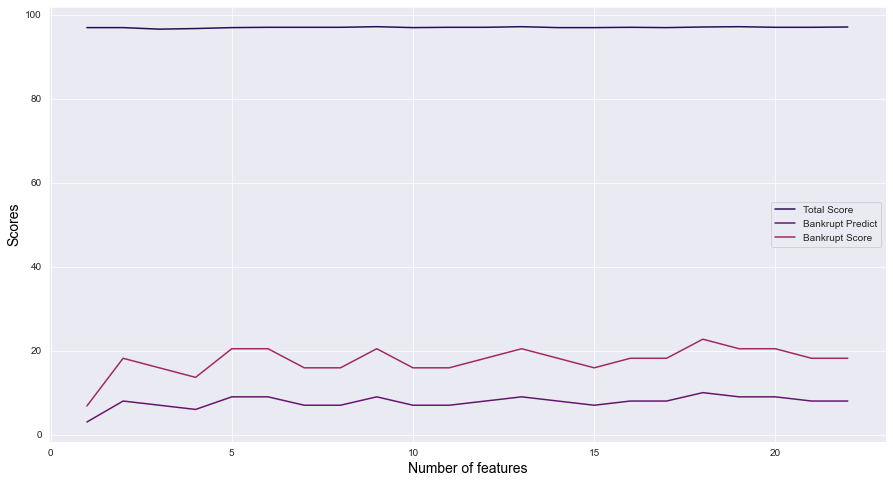

In [21]:
graphic1 = sns.lineplot(data=cbc_results, x='Features', y='Total Score', label='Total Score')
graphic1 = sns.lineplot(data=cbc_results, x='Features', y='Bankrupt Predict', label='Bankrupt Predict')
graphic1 = sns.lineplot(data=cbc_results, x='Features', y='Bankrupt Score', label='Bankrupt Score')
configuration(graphic1, xlabel='Number of features', ylabel='Scores')

In [24]:
print('BEST FEATURES FOR MODEL WITH CATBOOST')
name_features_per_iteration[18]

BEST FEATURES FOR MODEL WITH CATBOOST


['Net Income to Total Assets',
 'Net worth/Assets',
 'Persistent EPS in the Last Four Seasons',
 'Retained Earnings to Total Assets',
 'Net profit before tax/Paid-in capital',
 'Per Share Net profit before tax (Yuan ¥)',
 'Working Capital to Total Assets',
 "Net Income to Stockholder's Equity",
 'Net Value Per Share (A)',
 'CFO to Assets',
 'Cash/Total Assets',
 'Gross Profit to Sales',
 'Equity to Long-term Liability',
 'Current Liability to Equity',
 'Current Liability to Current Assets',
 'Borrowing dependency',
 'Current Liability to Assets',
 'Debt ratio %']

In [44]:
correct_predict = cbc_results['Bankrupt Predict'].max()
print(f'Number of bankrupt campanies in validation data: {y_test.sum()}\nNumber of bankrupt companies predicted: {y_predict.sum()}')
print(f'Number of bankrupt companies correctly predicted: {correct_predict}')

Number of bankrupt campanies in validation data: 44
Number of bankrupt companies predicted: 12
Number of bankrupt companies correctly predicted: 10


## Observations and conclusions

- the model fails to understand the differences very well in order to correctly classify the companies that are going to fail
- it is important transform variables for create more differences between them
- I will use the 18 variables which take the better results for classification

In [47]:
new_dataset = dataset[name_features_per_iteration[18]]
new_dataset['Bankrupt'] = dataset['Bankrupt']

#save new dataset
new_dataset.to_csv('18_feature_selected.csv', index=False)